In [1]:
import os
import sys
import argparse
import distutils.core
import cv2
import matplotlib.pyplot as plt
import torch
torch.cuda.is_available()

True

import distutils.core
dist = distutils.core.run_setup("./detectron2/setup.py")
sys.path.insert(0, os.path.abspath('../detectron2'))

In [3]:
from datasets import *
from bodyhands import *
from bodyhands import add_bodyhands_config
from bodyhands import CustomVisualizer
from detectron2.data import MetadataCatalog
from detectron2.modeling import build_model
from detectron2.config import get_cfg
import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import MetadataCatalog

In [4]:
class CustomPredictor:

    def __init__(self, cfg):
        self.cfg = cfg.clone()  
        self.model = build_model(self.cfg)
        self.model.eval()
        self.metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

        checkpointer = DetectionCheckpointer(self.model)
        checkpointer.load(cfg.MODEL.WEIGHTS)

        self.input_format = cfg.INPUT.FORMAT
        assert self.input_format in ["RGB", "BGR"], self.input_format

    def __call__(self, original_image):
        with torch.no_grad():  
            if self.input_format == "RGB":
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            image = torch.as_tensor(original_image.astype("float32").transpose(2, 0, 1))
            inputs = {"image": image, "height": height, "width": width}
            predictions = self.model([inputs], height, width)[0]
            return predictions

def prepareModel(cfg_file, weights, thresh):
    cfg = get_cfg()
    add_bodyhands_config(cfg)
    cfg.merge_from_file(cfg_file)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = thresh
    cfg.MODEL.WEIGHTS = os.path.abspath(weights)
    predictor = CustomPredictor(cfg)
    return predictor

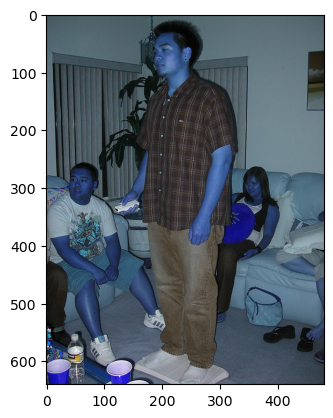

In [5]:
# images_path = os.path.abspath('D:\PuMuxin\FreiHand\orginal\naked_hands')
# out_path = os.path.abspath('./demoOutput/')
# if not os.path.exists(out_path):
#     os.mkdir(out_path)

# images = sorted(os.listdir(images_path))
# totalImages = len(images)
# count = 0

roi_score_thresh = 0.7
model = prepareModel('./configs/BodyHands.yaml', './models/model.pth', roi_score_thresh)

image_path = "../examples/media/COCO_val2014_000000000241.jpg"
im = cv2.imread(image_path)
plt.imshow(im)
plt.show()

D:\Anaconda\envs\openpose-1.7.0\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
D:\Anaconda\envs\openpose-1.7.0\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


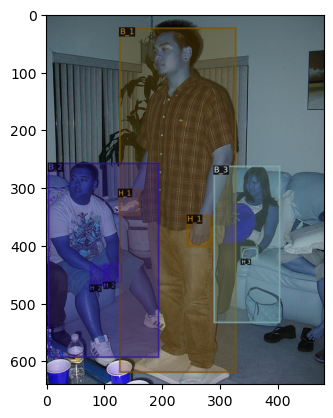

In [6]:
# filename = '00000010.jpg'
# count += 1
# print("Processing image # {}, total: {}".format(count, totalImages))
im = cv2.imread(image_path)
height, width = im.shape[:2]
ratio = width / height
outheight = 720
outwidth = int(ratio * outheight)
#     im = cv2.resize(im, (outwidth, outheight))
outputs = model(im)
v = CustomVisualizer(im[:, :, ::-1], MetadataCatalog.get("HandBodyContactHands_sub"), scale=1.0)
#######################################################################################
outputs = outputs["instances"].to("cpu")
classes = outputs.pred_classes
body_ids = outputs.pred_body_ids
boxes = outputs.pred_boxes.tensor
masks = outputs.pred_masks
hand_indices = classes == 0
body_indices = classes == 1
hand_boxes = boxes[hand_indices]
hand_masks = masks[hand_indices]
hand_body_ids = body_ids[hand_indices]
body_boxes = boxes[body_indices]
body_body_ids = body_ids[body_indices]
num_hands, num_bodies = hand_boxes.shape[0], body_boxes.shape[0]
body_masks = []
for body_no in range(num_bodies):
    box = body_boxes[body_no].view(-1).cpu().numpy()
    xmin, ymin, xmax, ymax = box
    body_poly = [[(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)]]
    body_masks.append(body_poly)
########################################################################################
v = v.modified_draw_instance_predictions(hand_boxes, hand_masks, hand_body_ids, body_boxes, body_masks, body_body_ids)
out = v.get_image()[:, :, ::-1]
# cv2.imwrite(os.path.join(out_path, filename), out)
plt.imshow(out)
plt.show()

In [7]:
hand_boxes

tensor([[243.4851, 347.7794, 287.4617, 401.5954],
        [125.0837, 303.3705, 161.6530, 348.0794],
        [ 99.8546, 432.2531, 128.9210, 463.9233],
        [ 75.7324, 435.4949, 108.1541, 469.2543],
        [337.4364, 403.0123, 365.2542, 423.7030]])

tensor([337.4364, 403.0123, 365.2542, 423.7030])


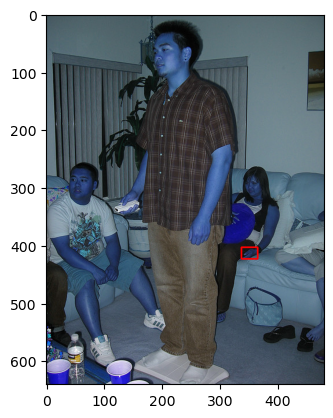

In [34]:
image = cv2.imread('D:\\PuMuxin\\BodyHands\\images\\COCO_val2014_000000000241.jpg')

hand_box = hand_boxes[4]
xmin, ymin, xmax, ymax = [int(x) for x in list(hand_box)]
print(hand_box)

cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

plt.imshow(image)
plt.show()

## Draft here, Put into hand_landmark_localisation eventually

In [79]:
# Import Openpose (Windows/Ubuntu/OSX)
dir_path = os.path.dirname(os.path.realpath('__file__'))
try:
    # Change these variables to point to the correct folder (Release/x64 etc.)
    sys.path.append(dir_path + '/../bin/python/openpose/Release');
    os.environ['PATH']  = os.environ['PATH'] + ';' + dir_path + '/../x64/Release;' +  dir_path + '/../bin;'
    import pyopenpose as op
except ImportError as e:
    print('Error: OpenPose library could not be found. Did you enable `BUILD_PYTHON` in CMake and have this Python script in the right folder?')
    raise e
    
def extend_hand_box(box, image_height, image_width, extend):
    xmin, ymin, xmax, ymax = box 
    for i in range(extend):
        if xmin == 0 and xmax < image_width: 
            xmax += 1
            extend += 1
        elif xmin > 0 and xmax == image_width: 
            xmin -= 1
            extend += 1
        elif xmin <= 0 and xmax >= image_width:
            pass
        else: 
            xmin, xmax = xmin - 1, xmax + 1

        if ymin == 0 and ymax < image_height: 
            ymax += 1
            extend += 1
        elif ymin > 0 and ymax == image_height:
            ymin -= 1
            extend += 1
        elif ymin <= 0 and ymax >= image_height:
            pass
        else: 
            ymin, ymax = ymin - 1, ymax + 1
    
    xmin = 0 if xmin<0 else xmin
    ymin = 0 if ymin<0 else ymin
    xmax = image_width if xmax > image_width else xmax
    ymax = image_height if ymax > image_height else ymax
    
    return xmin, ymin, xmax, ymax

def find_bounded_sqaure(box):
    xmin, ymin, xmax, ymax = box 
    x = (xmax-xmin)/2 + xmin
    y = (ymax-ymin)/2 + ymin
    extend = max(xmax-xmin, ymax-ymin)/2 
    new_xmin, new_ymin = x-extend, y-extend
    new_xmax, new_ymax = x+extend, y+extend
    return new_xmin, new_ymin, new_xmax, new_ymax

def convert_to_op_rectangle(box, image_height, image_width, extend=50):
    bounded_sqaure = find_bounded_sqaure(box)
#     print(bounded_sqaure)
    xmin, ymin, xmax, ymax = extend_hand_box(bounded_sqaure, image_height, image_width, extend)
    width = abs(xmax - xmin)
    height = abs(ymax - ymin)
    length = max(width, height)
    hand_rectangle = op.Rectangle(xmin, ymin, length, length)
    return hand_rectangle

In [80]:
hand_boxes_copy = []
for box in hand_boxes:
    box_copy = []
    for value in box: 
        box_copy.append(float(value))
    hand_boxes_copy.append(box_copy)
print("hand_boxes_copy: " + str(hand_boxes_copy))

height, width = im.shape[:2]
# We are considering every seen hand is a left hand
hands_rectangles = [[convert_to_op_rectangle(box, height, width, 50), op.Rectangle(0., 0., 0., 0.)] for box in hand_boxes_copy]
print("hands_rectangles: " + str(hands_rectangles))

hand_boxes_copy: [[243.48513793945312, 347.7793884277344, 287.4617004394531, 401.5953674316406], [125.08369445800781, 303.3705139160156, 161.65296936035156, 348.0794372558594], [99.85457611083984, 432.2530822753906, 128.92103576660156, 463.9233093261719], [75.73243713378906, 435.4949035644531, 108.15406799316406, 469.2543029785156], [337.4364318847656, 403.0123291015625, 365.2542419433594, 423.7030029296875]]
hands_rectangles: [[[188.565430, 297.779388, 153.815979, 153.815979], [0.000000, 0.000000, 0.000000, 0.000000]], [[71.013870, 253.370514, 144.708923, 144.708923], [0.000000, 0.000000, 0.000000, 0.000000]], [[48.552692, 382.253082, 131.670227, 131.670227], [0.000000, 0.000000, 0.000000, 0.000000]], [[25.063553, 385.494904, 133.759399, 133.759399], [0.000000, 0.000000, 0.000000, 0.000000]], [[287.436432, 349.448761, 127.817810, 127.817810], [0.000000, 0.000000, 0.000000, 0.000000]]]


In [70]:
sqaure = [[238.5654296875, 347.7793884277344, 292.38140869140625, 401.5953674316406],
 [121.01387023925781, 303.3705139160156, 165.72279357910156, 348.0794372558594],
 [98.55269241333008, 432.2530822753906, 130.22291946411133, 463.9233093261719],
 [75.06355285644531, 435.4949035644531, 108.82295227050781, 469.2543029785156],
 [337.4364318847656, 399.4487609863281, 365.2542419433594, 427.2665710449219]]

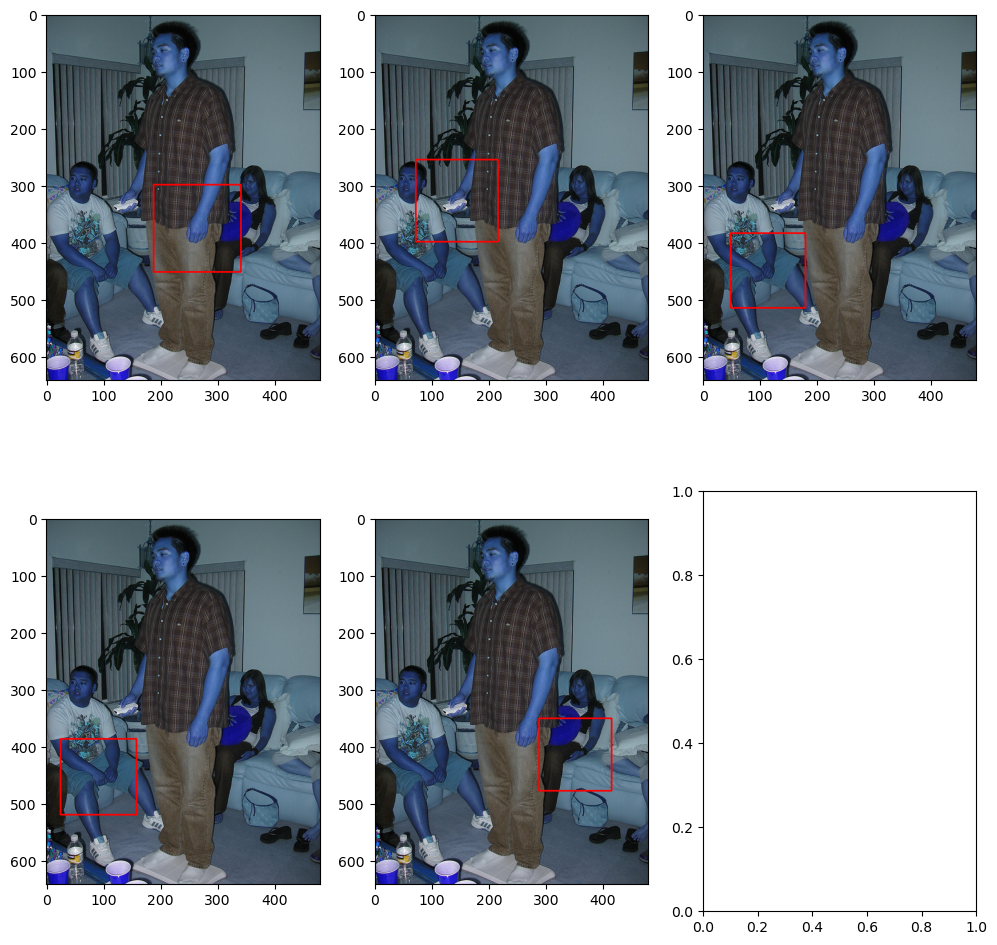

In [81]:
pre_hands_rectangles = [[[188.565430, 297.779388, 153.815979, 153.815979], [0.000000, 0.000000, 0.000000, 0.000000]], [[71.013870, 253.370514, 144.708923, 144.708923], [0.000000, 0.000000, 0.000000, 0.000000]], [[48.552692, 382.253082, 131.670227, 131.670227], [0.000000, 0.000000, 0.000000, 0.000000]], [[25.063553, 385.494904, 133.759399, 133.759399], [0.000000, 0.000000, 0.000000, 0.000000]], [[287.436432, 349.448761, 127.817810, 127.817810], [0.000000, 0.000000, 0.000000, 0.000000]]]
image = cv2.imread(image_path)
_, axs = plt.subplots(2, 3, figsize=(12, 12))
axs = axs.flatten()

i = 0
for ax in axs:
    if i == 5: 
        break 
    temp = image.copy()
    xmin, ymin, width, height = [int(x) for x in list(pre_hands_rectangles[i][0])]
    cv2.rectangle(temp, (xmin, ymin), (xmin+width, ymin+height), (255, 0, 0), 2)
    ax.imshow(temp)
    i += 1
plt.show()

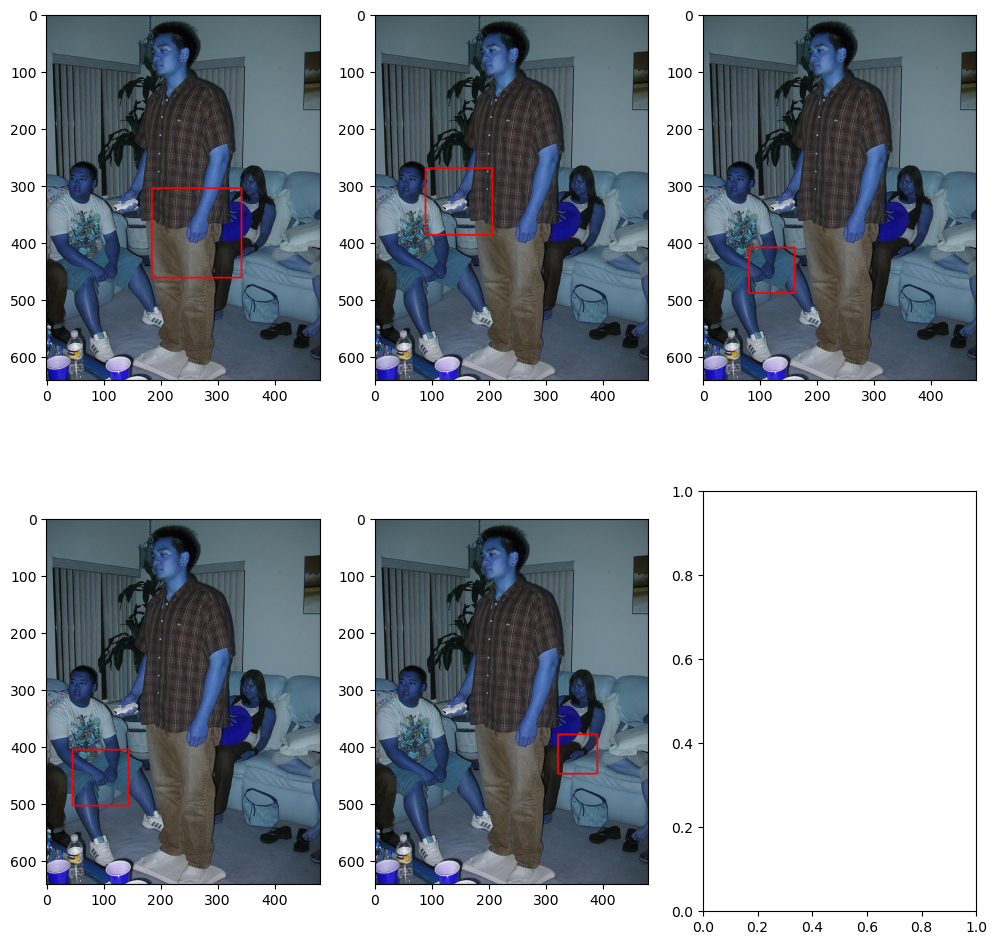

In [10]:
act_hands_rectangles = [[[185.692673, 303.112244, 157.587555, 157.587555],
  [0.000000, 0.000000, 0.000000, 0.000000]],
 [[88.984360, 268.866547, 117.818230, 117.818230],
  [0.000000, 0.000000, 0.000000, 0.000000]],
 [[80.155792, 407.673492, 80.812706, 80.812706],
  [0.000000, 0.000000, 0.000000, 0.000000]],
 [[46.449715, 404.559753, 98.898178, 98.898178],
  [0.000000, 0.000000, 0.000000, 0.000000]],
 [[320.035889, 377.675049, 69.300949, 69.300949],
  [0.000000, 0.000000, 0.000000, 0.000000]]]

image = cv2.imread('D:\\PuMuxin\\BodyHands\\images\\COCO_val2014_000000000241.jpg')
_, axs = plt.subplots(2, 3, figsize=(12, 12))
axs = axs.flatten()

i = 0
for ax in axs:
    if i == 5: 
        break 
    temp = image.copy()
    xmin, ymin, width, height = [int(x) for x in list(act_hands_rectangles[i][0])]
    cv2.rectangle(temp, (xmin, ymin), (xmin+width, ymin+height), (255, 0, 0), 2)
    ax.imshow(temp)
    i += 1
plt.show()

In [2]:
x =  [[215.20599365234375, 174.84100341796875, 1.0], [221.26699829101562, 187.0449981689453, 1.0], [224.43099975585938, 200.21400451660156, 1.0], [226.27000427246094, 214.0780029296875, 1.0], [0.0, 0.0, 0.0], [211.4250030517578, 207.96099853515625, 1.0], [211.02099609375, 220.02699279785156, 1.0], [214.05599975585938, 230.78500366210938, 1.0], [0.0, 0.0, 0.0], [206.22999572753906, 208.78799438476562, 1.0], [206.69400024414062, 222.4340057373047, 1.0], [210.70599365234375, 230.9199981689453, 1.0], [0.0, 0.0, 0.0], [203.89199829101562, 206.8990020751953, 1.0], [204.21400451660156, 218.5050048828125, 1.0], [208.5240020751953, 225.95399475097656, 1.0], [0.0, 0.0, 0.0], [202.8560028076172, 203.82200622558594, 1.0], [205.36099243164062, 216.6479949951172, 1.0], [209.06199645996094, 220.78599548339844, 1.0], [0.0, 0.0, 0.0]]

In [3]:
len(x)

21